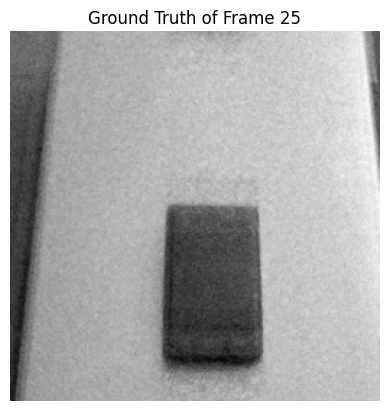

In [169]:
import helpers
import matplotlib.pyplot as plt
import numpy as np
import torch
from helpers import SPDER_Network
import os
import torch

model_input = helpers.read("serialized/video_bikes/model_input_bikes_video")

print(model_input.shape)

SPDER_trained_model = SPDER_Network(in_features=3, 
                        out_features=1, 
                        hidden_layers=12,
                        nums_neurons=1024,
)

print("Using", torch.cuda.device_count(), "GPUs")
SPDER_trained_model = torch.nn.DataParallel(SPDER_trained_model)

SPDER_trained_model = SPDER_trained_model.to(model_input.device)

# Load previous model
SPDER_trained_model.module.load_state_dict(torch.load('serialized/video_bikes/bikes_video5.0e-06SPDER.pth'))

SPDER_trained_model = SPDER_trained_model.cuda()

frame_num = 25
batch_size = 8192  # Adjust this value based on your available GPU memory

# Assuming model_input is a torch tensor of shape [1, 256*256*frame_num, 1]
start_idx = int(256 * 256 * (frame_num))
end_idx = int(256 * 256 * (frame_num + 1))
total_elements = end_idx - start_idx

# Initialize an empty output tensor
output = torch.zeros((1, total_elements, 1)).cuda()

# Process the input in smaller batches
for i in range(0, total_elements, batch_size):
    batch_input = model_input[:, start_idx:start_idx+batch_size, :]
    
    print(batch_input)
    
    batch_input = batch_input + torch.tensor([0, 0, 0]).cuda()
    
    # Run the forward pass on the current batch
    with torch.no_grad():
        batch_output, _ = SPDER_trained_model(batch_input)
    
    # Concatenate the batch output to the final output tensor
    output = torch.cat((output, batch_output), dim=1)

    # Update start_idx for the next batch
    start_idx += batch_size

# Remove the initial zeros from the output tensor
output = output[:, output.shape[1] // 2:, :]
print(output.shape)

model_pred = output.cpu().view(256, 256).detach().numpy()
plt.imshow(model_pred, cmap='gray')
plt.title("SPDER Reconstruction of Frame " + str(frame_num + 0.5))
plt.axis("off")
plt.show()

ground_truth = helpers.read("serialized/video_bikes/ground_truth_bikes_video")
ground_truth = ground_truth[:, 256*256*(frame_num):256*256*(frame_num+1), :].cpu().detach().numpy()
gt = output.cpu().view(256, 256).detach().numpy()
plt.title("Ground Truth of Frame " + str(frame_num))
plt.imshow(gt, cmap='gray')
plt.axis("off")
plt.show()

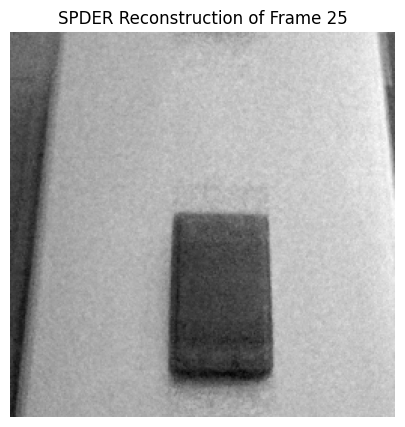

In [165]:
def plot_frame(frame_num, model_input, SPDER_trained_model, batch_size=8192):
    start_idx = int(256 * 256 * (frame_num))
    end_idx = int(256 * 256 * (frame_num + 1))
    total_elements = end_idx - start_idx

    # Initialize an empty output tensor
    output = torch.zeros((1, total_elements, 1)).cuda()

    # Process the input in smaller batches
    for i in range(0, total_elements, batch_size):
        batch_input = model_input[:, start_idx:start_idx+batch_size, :]
        
        # Run the forward pass on the current batch
        with torch.no_grad():
            batch_output, _ = SPDER_trained_model(batch_input)
        
        # Concatenate the batch output to the final output tensor
        output = torch.cat((output, batch_output), dim=1)

        # Update start_idx for the next batch
        start_idx += batch_size

    # Remove the initial zeros from the output tensor
    output = output[:, output.shape[1] // 2:, :]

    model_pred = output.cpu().view(256, 256).detach().numpy()
    
    return model_pred

frame_nums = [25]

plt.figure(figsize=(15, 5))

for i, frame_num in enumerate(frame_nums):
    model_pred = plot_frame(frame_num, model_input, SPDER_trained_model)
    plt.subplot(1, len(frame_nums), i + 1)
    plt.imshow(model_pred, cmap='gray')
    plt.title("SPDER Reconstruction of Frame " + str(frame_num))
    plt.axis("off")

plt.show()


In [103]:
import helpers
import matplotlib.pyplot as plt
import numpy as np
import torch
from helpers import SPDER_Network
import os
import torch

model_input = helpers.read("serialized/video_bikes/model_input_bikes_video")

SPDER_trained_model = SPDER_Network(in_features=3, 
                        out_features=1, 
                        hidden_layers=12,
                        nums_neurons=1024,
)

print("Using", torch.cuda.device_count(), "GPUs")
SPDER_trained_model = torch.nn.DataParallel(SPDER_trained_model)

SPDER_trained_model = SPDER_trained_model.to(model_input.device)
    
# Load previous model
SPDER_trained_model.module.load_state_dict(torch.load('serialized/video_bikes/bikes_video5.0e-06SPDER.pth'))

SPDER_trained_model = SPDER_trained_model.cuda()

frame_num = 151
batch_size = 512  # Adjust this value based on your available GPU memory

# Assuming model_input is a torch tensor of shape [1, 256*256*frame_num, 1]
start_idx = int(256 * 256 * (frame_num))
end_idx = int(256 * 256 * (frame_num + 1))
total_elements = end_idx - start_idx

# Initialize an empty output tensor
interpolated_output = torch.zeros((1, total_elements, 1)).cuda()

# Process the input in smaller batches
for i in range(0, total_elements, batch_size):
    batch_input = model_input[:, start_idx:start_idx+batch_size, :]
    
    batch_input = batch_input + torch.tensor([1/250, 0, 0]).cuda()
    
    # Run the forward pass on the current batch
    with torch.no_grad():
        batch_output, _ = SPDER_trained_model(batch_input)
    
    # Concatenate the batch output to the final output tensor
    interpolated_output = torch.cat((interpolated_output, batch_output), dim=1)

    # Update start_idx for the next batch
    start_idx += batch_size

# Remove the initial zeros from the output tensor
interpolated_output = interpolated_output[:, interpolated_output.shape[1] // 2:, :]
interpolated_output.shape

Using 2 GPUs


torch.Size([1, 65536, 1])

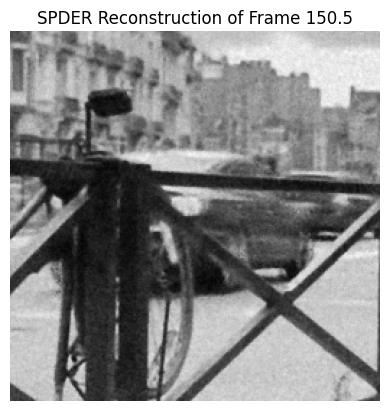

In [104]:
model_pred = interpolated_output.cpu().view(256, 256).detach().numpy()
plt.imshow(model_pred, cmap='gray')
plt.title("SPDER Reconstruction of Frame 150.5")
plt.axis("off")
plt.show()

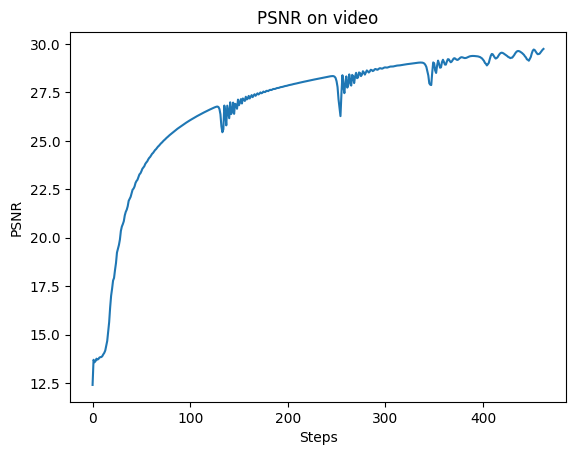

29.743615139088213

In [ ]:
import helpers
import matplotlib.pyplot as plt

l = helpers.read("bunny_video5.0e-06SPDER_losses.file")
l = [10*np.log10(4/i) for i in l]
plt.plot(l)
plt.title("PSNR on video")
plt.ylabel("PSNR")
plt.xlabel("Steps")
plt.show()

max(l)
